# Incremental Insertion und Randomized Incremental Insertion
## Tim Krampitz, Felix Roscher
11.01.2019

## Grundlagen

In [12]:
import numpy as np
import matplotlib.pyplot as plt

Drei Punkte machen eine Linksumdrehung, wenn ihre Determinate postiv ist
$$ \Delta(a,b,c) = \begin{vmatrix} 1 & x_a & y_a  \\ 1 & x_b & y_b  \\ 1 & x_c & y_c  \end{vmatrix} > 0$$

In [13]:
def isLeftTurn(a,b,c):
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0]) > 0

In [14]:
def getAngle(anchor, point):
    diff = point - anchor
    return np.arctan2(diff[1], diff[0])

In [15]:
def findAchorPointIndex(pts):
    return np.argsort(pts[:,1])[0]

In [16]:
def sortCCW(anchorIndex, pts):
    lst = np.delete(pts, anchorIndex, axis=0)
    
    angles = [ getAngle(pts[anchorIndex], point) for point in lst ]
    return lst[np.argsort(angles)]

## Incremental Insertion (Sweeping)

## sweepHull

1. Sortiere die Punkte nach aufsteigender x-Koordinate

2. Initialisierung mit 1 . und 2 . Punkt als triviale konvexe Hülle

3. Hinzufügen des nächst linken Punktes 
   - Prüfen ob Y-Koordinate kleiner/größer als vorheriger Punkt für korrekte Reihenfolge
   - Setzen des Vorgänger und Nachfolgers des neuen Punkts
   - Hinzufügen des neuen Punkts als Nachfolger/Vorgänger der angrenzenden Punkte 

4. Prüfen ob Vorgänger eine "Linksdrehung" darstellen

5. Analoge Prüfung Nachfolger auf "Linksdrehung"

In [17]:
def sortXIndex(pts):    
    return np.argsort(pts[:,0])

In [18]:
def grahamScan(pts):
    anchorIndex = findAchorPointIndex(pts)
    anchor = pts[anchorIndex]
    ptsCCW = sortCCW(anchorIndex, pts)
    hull = np.empty((0,2))    
    
    for p in ptsCCW:
        hull = np.vstack((hull, p))
        while len(hull) >= 3:
            i = len(hull) - 1
            if not isLeftTurn(hull[i-2],hull[i-1],hull[i]):
                hull = np.delete(hull, i-1, axis=0)
            else:
                break
    hull = np.vstack((hull, anchor))
    hull = np.insert(hull, 0 ,anchor, axis=0)
    return hull

In [19]:
class SweepPoint:
    def __init__(self, x = 0, y = 0):
        self.x = x
        self.y = y

    def __repr__(self):
        return "X:" + str(self.x) + " Y:" + str(self.y) + " Next:" + str(self.next) + " Prev:" + str(self.prev)
    
    def toList(self):
        return [self.x, self.y]

Klassendefinition eines Knotenpunktes mit Koordinaten, Nachfolger und Voränger

toList(self): Schreibt Koordinaten als Punkt (x,y)

In [20]:
def sweepHull(pts):
    lst = [ SweepPoint(pts[i][0],pts[i][1]) for i in sortXIndex(pts) ] # nach X aufs. sortierte Liste mit SweepPoint Objeketen
    lst[0].next = 1
    lst[0].prev = 1
    
    lst[1].next = 0
    lst[1].prev = 0 # Startbedingung, Zweipunktkonvexhülle
    
    for i in range(2, len(lst)):
        if lst[i].y < lst[i-1].y:
            lst[i].next = i-1
            lst[i].prev = lst[i-1].prev
        else:
            lst[i].prev = i-1
            lst[i].next = lst[i-1].next
        
        lst[lst[i].prev].next = i
        lst[lst[i].next].prev = i
        
        while isLeftTurn(lst[i].toList(), lst[lst[i].prev].toList(), lst[lst[lst[i].prev].prev].toList()):
            lst[lst[lst[i].prev].prev].next = i
            lst[i].prev = lst[lst[i].prev].prev
            
        while isLeftTurn(lst[lst[lst[i].next].next].toList(), lst[lst[i].next].toList(), lst[i].toList()):
            lst[lst[lst[i].next].next].prev = i
            lst[i].next = lst[lst[i].next].next

    out = [lst[0]]
    while out[len(out) - 1].next != 0:
        out.append(lst[out[len(out) - 1].next])
    out.append(lst[out[len(out) - 1].next])
    return [i.toList() for i in out]            

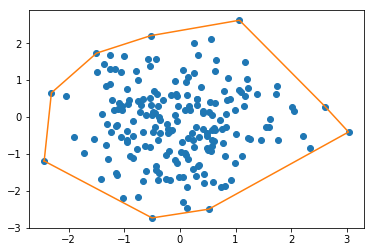

In [21]:
pts =  np.random.normal(size=(200,2))
hull = np.array(sweepHull(pts))

plt.plot(pts[:,0], pts[:,1], 'o')
plt.plot(hull[:,0], hull[:,1])
plt.show()


## Korrektheit
   - nach jeder Iteration korrekte konvexe Hülle
   - Hinzufügen eines neuen Punkts p:
       - höhentechnisch zwischen zwei Punkten (korrekte, lineare Reihenfolge)
       - wiederholte Prüfung auf Linksdrehung der Winkel mit den Vorgängerpunkten von p
           - wenn Rechtsdrehung $\rightarrow$ fertig
           - wenn Linksdrehung $\rightarrow$ Vorgänger wird entfernt, erneute Überprüfung mit neuen Vorgängern
       - wiederholte Prüfung auf Linksdrehung der Winkel mit den Nachfolgerpunkten von p
           - analoge Vorgehensweise

## Laufzeit
   - Sortierung: $\mathcal{O}(n*log(n))$
   - Hinzufügen eines neuen Punktes: $\mathcal{O}(n)$
   - Gesamte Zeitkomplexität: $\mathcal{O}(n*log(n))$ 

## Randomized Incremental Insertion

## Algorithmus

1. Wähle zufällig drei Punkte als Starthülle

2. Füge Pointer für alle Punkte e(p) und hinzu sowie conflictList der Kanten
    - Prüfe ob innerhalb der dreieckigen Hülle $\rightarrow e(p)=null$
    - Finde nächste, sichbare Kante

3. Wähle zufälligen Punkt p mit $e(p) \neq null$

4. Füge p der Hülle hinzu, zwischen die Eckpunkte von $e(p)$

5. Repariere polygon wie bei sweepHull Algorithmus
    - Bei Entfernung von Kante k alle Punkte m mit $e(m)=k$ makieren sowie Eckpunkte von k

6. Ermittle Pointer aller markierten Punkte m erneut
    - Punkt ist innerhalb des Dreiecks prev(p),p,next(p)
        - $e(m) = null$
        - Setzte neuen $e(m)$ auf neue sichtbare Kante (entweder $[prev(p),p]$ oder $[p,next(p)]$)

7. Gehe zu Schritt 3 bis kein Punkte mit Pointer mehr übrig ist

## Korrektheit und Laufzeit

* Korrektheit:
    - Alle Punkte werden angefasst/betrachtet
    - Nach jeder Iteration korrekte konvexe Hülle 

* Laufzeit:
    - Definiert durch
        - Anzahl der Entfernungen von Hüllen- bzw Eckpunkten
        - Anzahl der Änderungen der conflict pointer
        - Beides Laufzeit von 1

- worst case
    - Zeitkomplexität von $\Omega (n^2) $
    - Naiv: n Punkte, n-1 Pointerwechsel $\rightarrow n^2$

- Zufall, erwartete Anzahl: $\mathcal{O}(n*log (n)$
    - beliebiges Paar von i, mit $e_i(p_j)$ also Einfügen von Punkt j nach bereits i eingefügten Punkten
    - wenn $p_j$ schon eingefügt wurde bzw $p_j=null$
    - $E[$Anzahl der conflict pointer Änderungen$]  \leq \sum_{i=1}^n \sum_{j=1}^n Pr[ e_i(p_j) = e_{i-1}p_j]$

- Rückwärtsanalyse: Eine Entfernung ändert den Pointer nur wenn:

1. q war Teil der Hülle: q wurde entfernt

2. q war innerhalb der Hülle: q ist danach außerhalb

3. q war außerhalb der Hülle: Ein Eckpunkt von $e(q)$ wurde entfernt
    - Fall $1$ und $2 \leq n$
    - Fall 3
        - Wahrscheinlichkeit, dass Punkt i entfernt wird $\frac{1}{i}$
        - Wahrscheinlichkeit, dass ein Eckpunkt der Kante $e(i)$ entfernt wird $\frac{2}{i}$
        - $\sum_{i=1}^n \sum_{j=1}^n Pr[e_i(p_j) = e_{i-1}p_j] \leq n + \sum_{i=1}^n \sum_{j=1}^n \frac{2}{i}$
    - $= n + 2nH_n = \mathcal{O}(n log n)$

## Quellen

Notizen von Jeff Erickson (caj)<br>
http://www.faculty.jacobs-university.de/llinsen/teaching/320201/Lecture25.pdf

### Vielen Dank für Eure Aufmerksamkeit